# Part 4: Build the Right Model - Machine Learning

---

## Learning Objectives

This notebook demonstrates **Module 4: Machine Learning Essentials**

> Select appropriate algorithms and optimize performance for real-world impact

You'll learn to:
- Build baseline regression models
- Use ensemble methods (Random Forest)
- Evaluate model performance properly
- Tune hyperparameters for optimization
- Understand feature importance

**The Goal**: Build production-ready forecasting models that deliver measurable business value.

---

## Key Insight from Your Slide

> **"Not every problem needs a massive, expensive AI model."**

We'll start simple and build up - demonstrating when to use each approach.

---

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sys.path.append('../utils')
from helpers import set_plot_style, print_model_metrics, compare_models

set_plot_style()

print("Libraries loaded successfully")

Libraries loaded successfully


## Load Cleaned Data

In [14]:
df = pd.read_csv('../data/processed/sales_cleaned_sample.csv', parse_dates=['date'])

print(f"Loaded {df.shape[0]:,} sales records")
print(f"Features: {df.shape[1]} columns")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

df.head()

Loaded 42,100 sales records
Features: 23 columns
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,month,day,day_of_week,day_name,week_of_year,quarter,is_weekend,is_month_start,is_month_end,has_sales
0,729,2013-01-01,3,BEVERAGES,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0
1,733,2013-01-01,3,CLEANING,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0
2,734,2013-01-01,3,DAIRY,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0
3,738,2013-01-01,3,GROCERY I,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0
4,756,2013-01-01,3,PRODUCE,0.0,0,Quito,Pichincha,D,8,...,1,1,1,Tuesday,1,1,0,1,0,0


## Feature Engineering for ML

### Prepare Features for Modeling

In [15]:
# Create lag features (past sales)
df = df.sort_values(['store_nbr', 'family', 'date'])

# For each store-family combination, create lag features
df['sales_lag_7'] = df.groupby(['store_nbr', 'family'])['sales'].shift(7)
df['sales_lag_14'] = df.groupby(['store_nbr', 'family'])['sales'].shift(14)
df['sales_lag_30'] = df.groupby(['store_nbr', 'family'])['sales'].shift(30)

# Rolling averages
df['sales_rolling_7'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
lambda x: x.rolling(window=7, min_periods=1).mean()
)
df['sales_rolling_30'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
lambda x: x.rolling(window=30, min_periods=1).mean()
)

# Drop rows with NaN from lag features
df = df.dropna(subset=['sales_lag_7', 'sales_lag_14', 'sales_lag_30'])

print(f"Created lag and rolling features")
print(f"Remaining records: {df.shape[0]:,}")
print(f"\nNew features: sales_lag_7, sales_lag_14, sales_lag_30, sales_rolling_7, sales_rolling_30")

Created lag and rolling features
Remaining records: 41,350

New features: sales_lag_7, sales_lag_14, sales_lag_30, sales_rolling_7, sales_rolling_30


### Select Features for Modeling

In [16]:
# Select features
feature_cols = [
    'onpromotion', 'dcoilwtico', 'is_holiday', 'is_weekend',
    'day_of_week', 'month', 'quarter', 'year',
    'sales_lag_7', 'sales_lag_14', 'sales_lag_30',
    'sales_rolling_7', 'sales_rolling_30'
]

# Encode categorical variables using factorize (works with any dtype)
df['store_encoded'], _ = pd.factorize(df['store_nbr'])
df['family_encoded'], _ = pd.factorize(df['family'])
df['city_encoded'], _ = pd.factorize(df['city'])
df['type_encoded'], _ = pd.factorize(df['type'])

feature_cols.extend(['store_encoded', 'family_encoded', 'city_encoded', 'type_encoded'])

X = df[feature_cols]
y = df['sales']

# Check for any remaining NaN values
nan_counts = X.isnull().sum()
if nan_counts.sum() > 0:
    print(f"Warning: Found {nan_counts.sum()} NaN values in features:")
    print(nan_counts[nan_counts > 0])
    print(f"\nDropping rows with NaN values...")
    # Drop rows with any NaN in features
    valid_mask = X.notnull().all(axis=1)
    X = X[valid_mask]
    y = y[valid_mask]
    df = df[valid_mask]
    print(f"Remaining records after dropping NaN: {len(X):,}")

print(f"\nFeature matrix: {X.shape}")
print(f"Target variable: {y.shape}")
print(f"\nFeatures being used:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

dcoilwtico    11825
dtype: int64

Dropping rows with NaN values...
Remaining records after dropping NaN: 29,525

Feature matrix: (29525, 17)
Target variable: (29525,)

Features being used:
1. onpromotion
2. dcoilwtico
3. is_holiday
4. is_weekend
5. day_of_week
6. month
7. quarter
8. year
9. sales_lag_7
10. sales_lag_14
11. sales_lag_30
12. sales_rolling_7
13. sales_rolling_30
14. store_encoded
15. family_encoded
16. city_encoded
17. type_encoded


## Train-Test Split

### Time Series Split (Chronological)

In [17]:
# For time series, we use chronological split
split_date = df['date'].quantile(0.8)

train_mask = df['date'] <= split_date
test_mask = df['date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set: {X_train.shape[0]:,} records ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} records ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nSplit date: {split_date}")
print(f"Train period: {df[train_mask]['date'].min()} to {df[train_mask]['date'].max()}")
print(f"Test period: {df[test_mask]['date'].min()} to {df[test_mask]['date'].max()}")

Training set: 23,625 records (80.0%)
Test set: 5,900 records (20.0%)

Split date: 2016-09-19 00:00:00
Train period: 2013-01-31 00:00:00 to 2016-09-19 00:00:00
Test period: 2016-09-20 00:00:00 to 2017-08-15 00:00:00


### Feature Scaling

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print("(Important for Linear Regression and regularized models)")

Features scaled using StandardScaler
(Important for Linear Regression and regularized models)


## Model 1: Linear Regression (Baseline)

### Start Simple - Establish Baseline Performance


MODEL 1: LINEAR REGRESSION (BASELINE)

📊 Linear Regression Performance Metrics
Mean Absolute Error (MAE):    773.51
Root Mean Squared Error (RMSE): 1,171.52
R² Score:                     0.8881
Mean Absolute % Error (MAPE):  15.12%



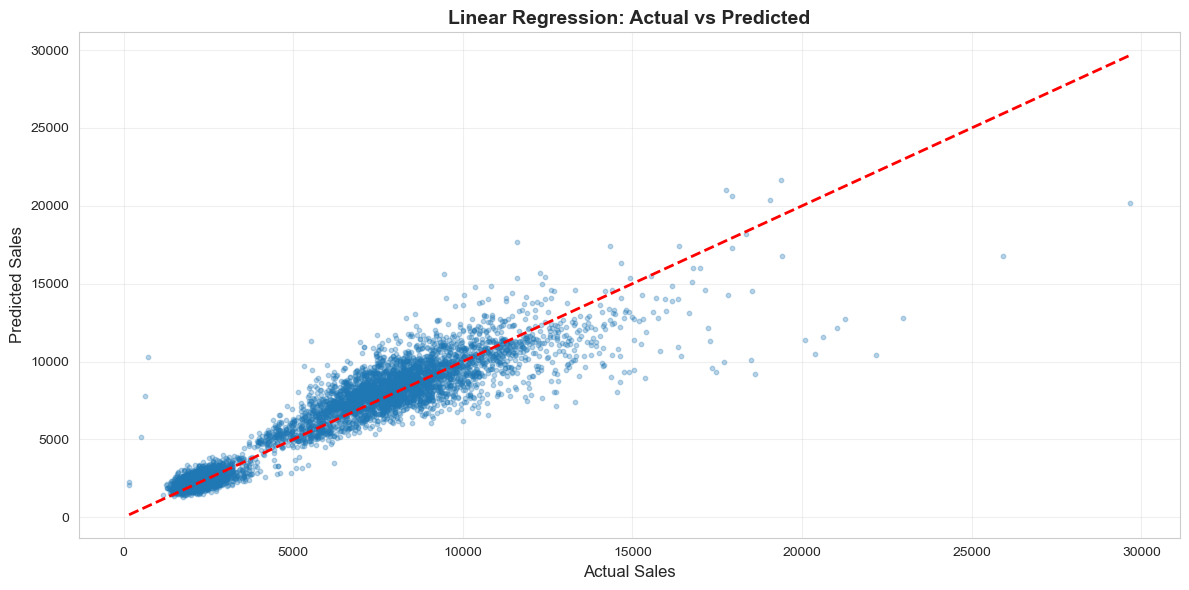

In [19]:
print("\n" + "="*70)
print("MODEL 1: LINEAR REGRESSION (BASELINE)")
print("="*70)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
lr_metrics = print_model_metrics(y_test, y_pred_lr, "Linear Regression")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Linear Regression: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Model 2: Random Forest (Capture Non-Linear Patterns)

### More Sophisticated - Handles Complex Relationships


MODEL 2: RANDOM FOREST REGRESSOR
Training Random Forest... (this may take a minute)

📊 Random Forest Performance Metrics
Mean Absolute Error (MAE):    605.23
Root Mean Squared Error (RMSE): 1,084.66
R² Score:                     0.9041
Mean Absolute % Error (MAPE):  10.85%



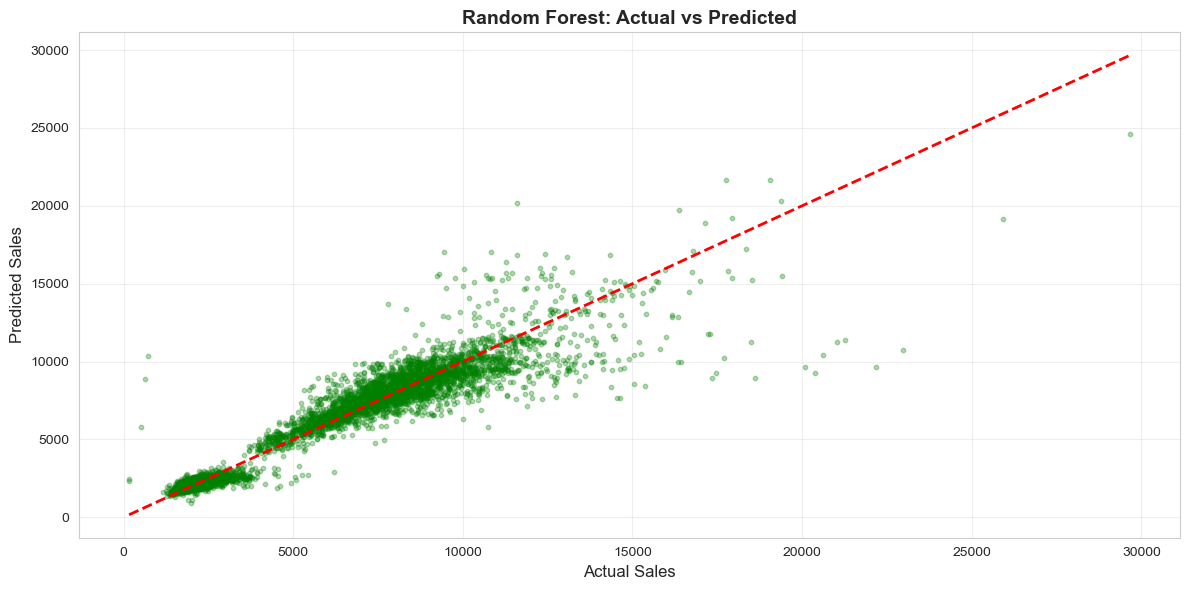

In [20]:
print("\n" + "="*70)
print("MODEL 2: RANDOM FOREST REGRESSOR")
print("="*70)

rf_model = RandomForestRegressor(
n_estimators=100,
max_depth=15,
min_samples_split=10,
min_samples_leaf=5,
random_state=42,
n_jobs=-1
)

print("Training Random Forest... (this may take a minute)")
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_metrics = print_model_metrics(y_test, y_pred_rf, "Random Forest")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, s=10, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Random Forest: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Importance Analysis

Top 10 Most Important Features:
             feature  importance
11   sales_rolling_7    0.893700
9       sales_lag_14    0.022497
0        onpromotion    0.021772
12  sales_rolling_30    0.015312
8        sales_lag_7    0.011149
4        day_of_week    0.009174
10      sales_lag_30    0.007700
2         is_holiday    0.004824
1         dcoilwtico    0.004667
5              month    0.004475


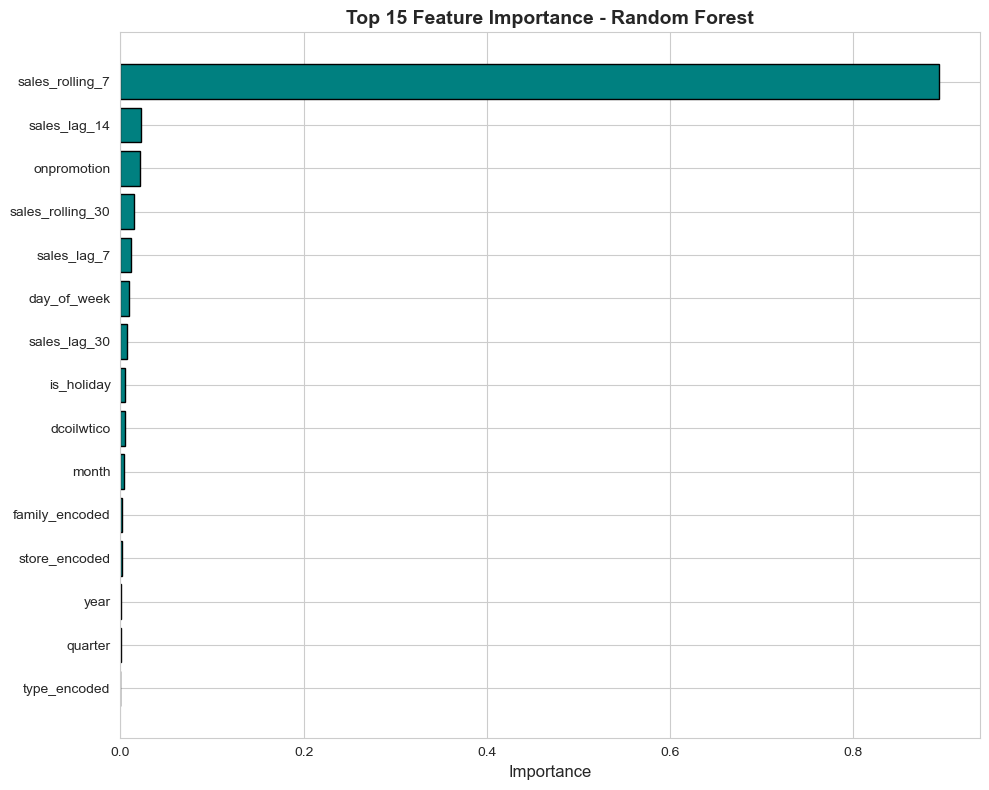

Insight: Past sales (lag features) are the strongest predictors!


In [21]:
# Get feature importance
feature_importance = pd.DataFrame({
'feature': feature_cols,
'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='teal', edgecolor='black')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"Insight: Past sales (lag features) are the strongest predictors!")

## Model 3: Gradient Boosting (Advanced Ensemble)

### State-of-the-Art Traditional ML


MODEL 3: GRADIENT BOOSTING REGRESSOR
Training Gradient Boosting... (this may take a minute)

📊 Gradient Boosting Performance Metrics
Mean Absolute Error (MAE):    612.43
Root Mean Squared Error (RMSE): 1,088.94
R² Score:                     0.9033
Mean Absolute % Error (MAPE):  10.91%



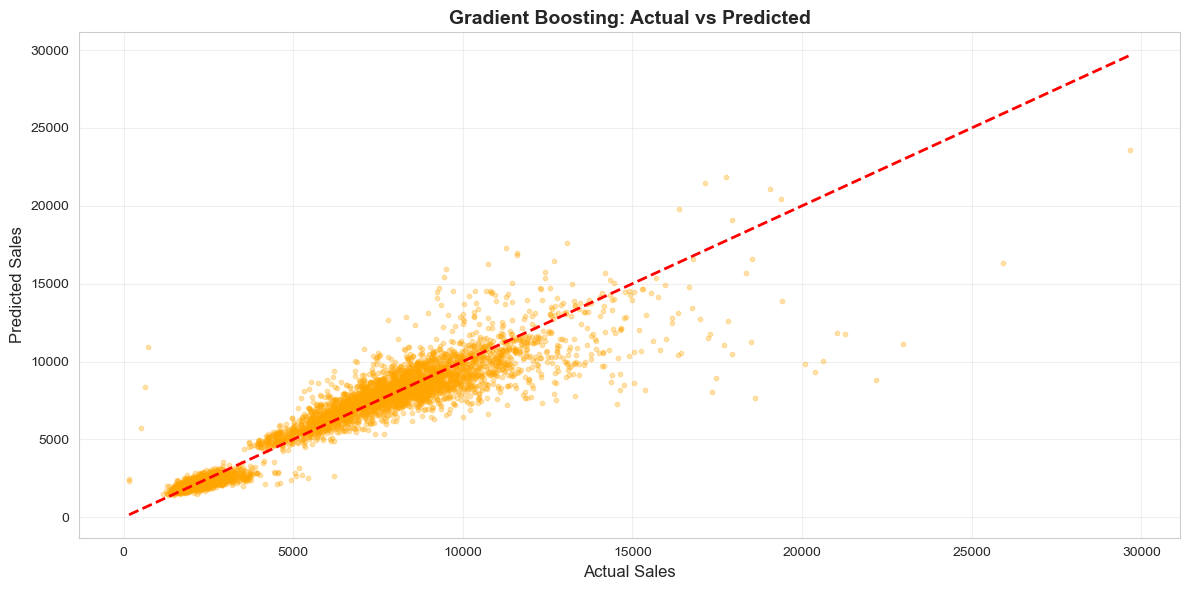

In [22]:
print("\n" + "="*70)
print("MODEL 3: GRADIENT BOOSTING REGRESSOR")
print("="*70)

gb_model = GradientBoostingRegressor(
n_estimators=100,
learning_rate=0.1,
max_depth=5,
min_samples_split=10,
min_samples_leaf=5,
random_state=42
)

print("Training Gradient Boosting... (this may take a minute)")
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate
gb_metrics = print_model_metrics(y_test, y_pred_gb, "Gradient Boosting")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.3, s=10, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Gradient Boosting: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Model Comparison

### Which Model is Best?


MODEL PERFORMANCE COMPARISON
                      MAE     RMSE    R2   MAPE
Linear Regression  773.51  1171.52  0.89  15.12
Random Forest      605.23  1084.66  0.90  10.85
Gradient Boosting  612.43  1088.94  0.90  10.91
Lower MAE, RMSE, MAPE = Better | Higher R² = Better


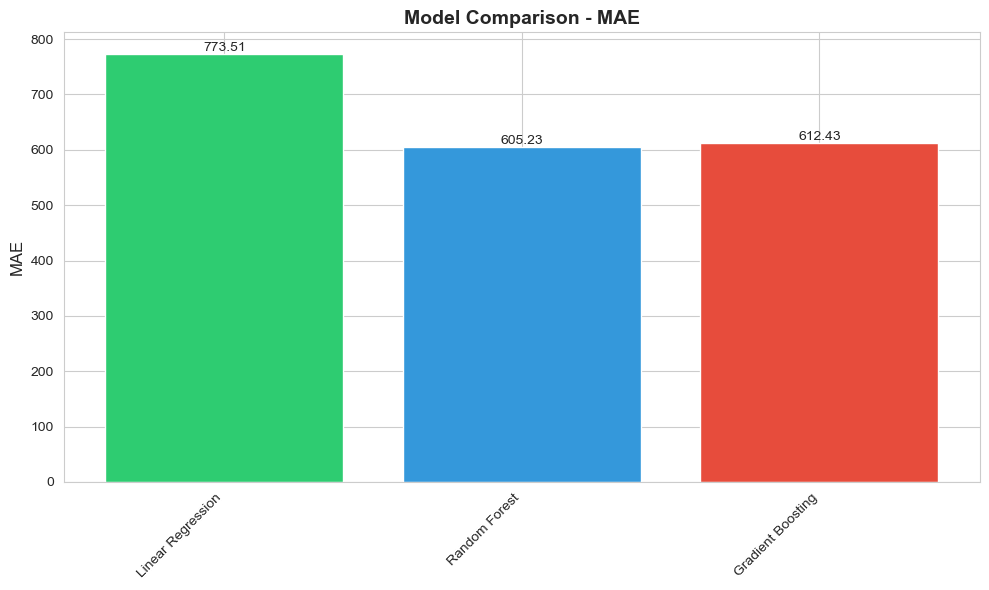

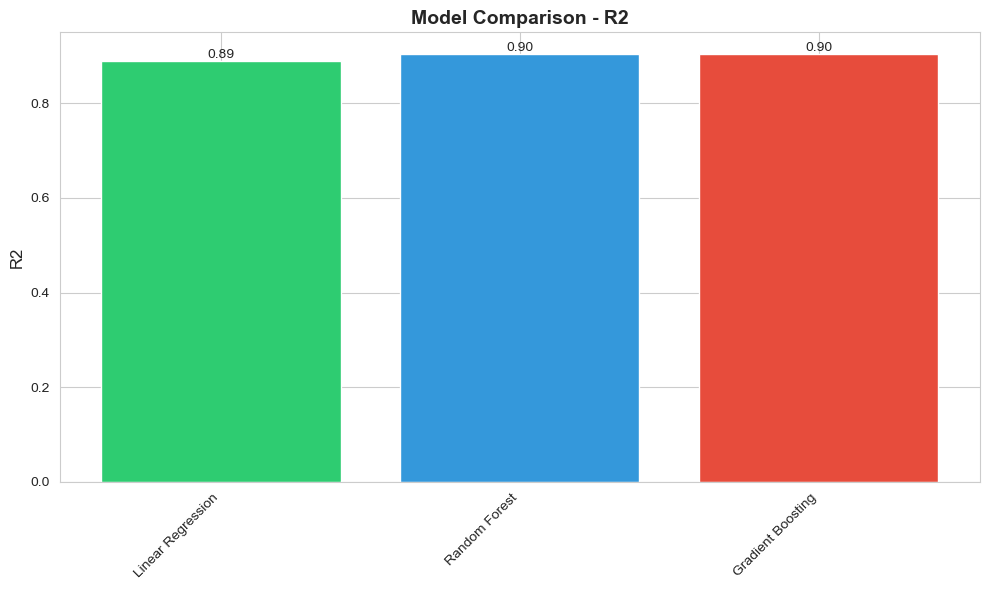

In [23]:
# Compile results
results = {
'Linear Regression': lr_metrics,
'Random Forest': rf_metrics,
'Gradient Boosting': gb_metrics
}

# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(2)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df)
print(f"Lower MAE, RMSE, MAPE = Better | Higher R² = Better")

# Visual comparison
compare_models(results, metric='MAE')
compare_models(results, metric='R2')

### Time Series Prediction Visualization

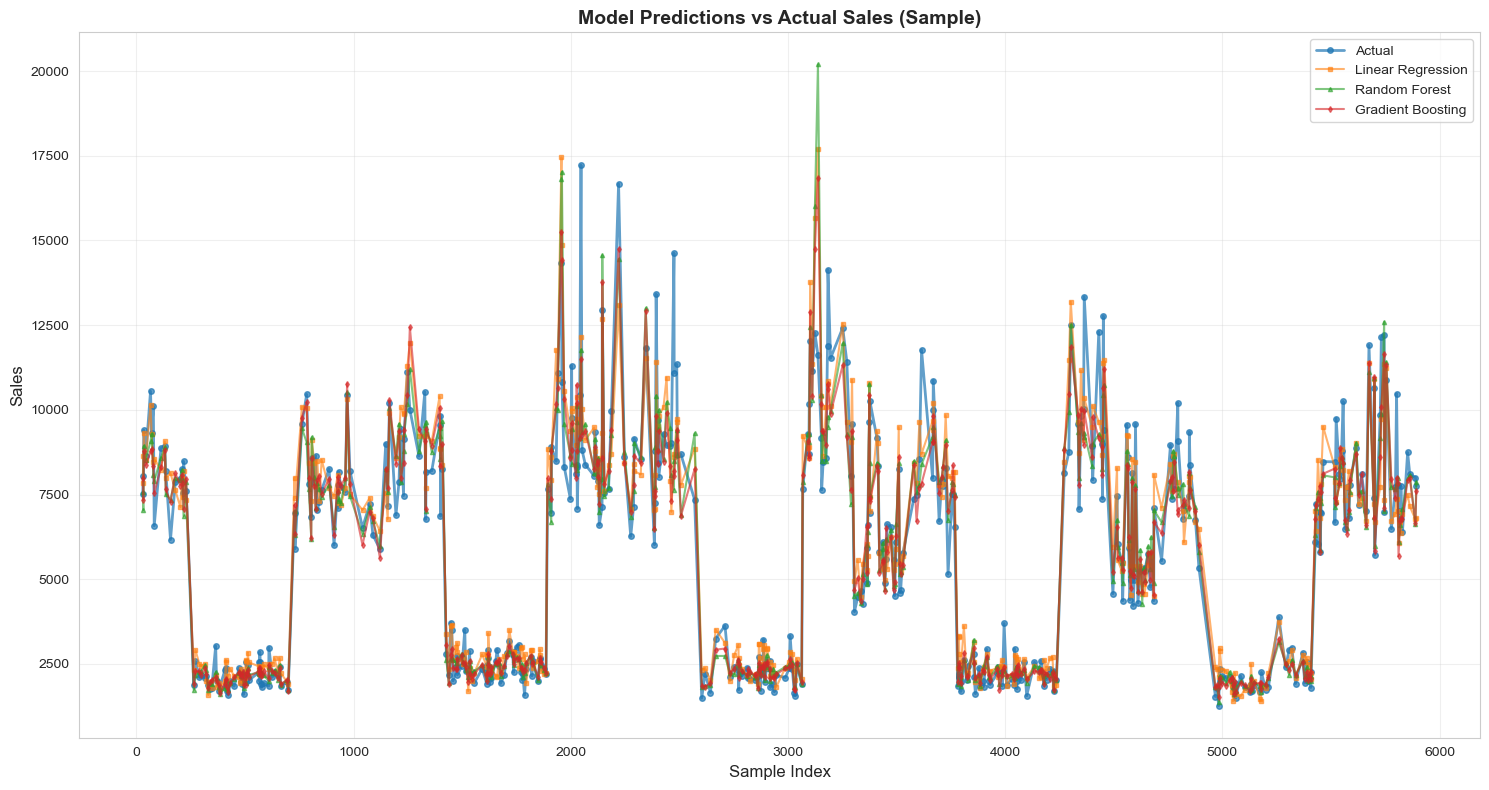

Notice how ensemble methods (RF, GB) capture patterns better than linear regression


In [24]:
# Get test dates for plotting
test_dates = df[test_mask]['date'].values

# Sample a subset for clearer visualization
sample_size = min(500, len(y_test))
sample_idx = np.random.choice(len(y_test), sample_size, replace=False)
sample_idx = np.sort(sample_idx)

plt.figure(figsize=(15, 8))

plt.plot(sample_idx, y_test.iloc[sample_idx], 'o-', label='Actual', 
linewidth=2, markersize=4, alpha=0.7)
plt.plot(sample_idx, y_pred_lr[sample_idx], 's-', label='Linear Regression', 
linewidth=1.5, markersize=3, alpha=0.6)
plt.plot(sample_idx, y_pred_rf[sample_idx], '^-', label='Random Forest', 
linewidth=1.5, markersize=3, alpha=0.6)
plt.plot(sample_idx, y_pred_gb[sample_idx], 'd-', label='Gradient Boosting', 
linewidth=1.5, markersize=3, alpha=0.6)

plt.xlabel('Sample Index')
plt.ylabel('Sales')
plt.title('Model Predictions vs Actual Sales (Sample)', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Notice how ensemble methods (RF, GB) capture patterns better than linear regression")

## Hyperparameter Tuning

### Optimize the Best Model (Random Forest)

In [25]:
print("\n" + "="*70)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("="*70)

# Define parameter grid
param_grid = {
'n_estimators': [50, 100, 150],
'max_depth': [10, 15, 20],
'min_samples_split': [5, 10, 15],
'min_samples_leaf': [2, 5, 10]
}

print(f"Searching for best parameters...")
print("(This will take several minutes - trying 81 combinations)")
print(f"Parameter grid:")
for param, values in param_grid.items():
    print(f"- {param}: {values}")

# Grid search with cross-validation
rf_tuned = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
rf_tuned, 
param_grid, 
cv=3, 
scoring='neg_mean_absolute_error',
verbose=1,
n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters found:")
print(grid_search.best_params_)

# Evaluate tuned model
y_pred_tuned = grid_search.best_estimator_.predict(X_test)
tuned_metrics = print_model_metrics(y_test, y_pred_tuned, "Tuned Random Forest")


HYPERPARAMETER TUNING - RANDOM FOREST
Searching for best parameters...
(This will take several minutes - trying 81 combinations)
Parameter grid:
- n_estimators: [50, 100, 150]
- max_depth: [10, 15, 20]
- min_samples_split: [5, 10, 15]
- min_samples_leaf: [2, 5, 10]
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:
{'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 150}

📊 Tuned Random Forest Performance Metrics
Mean Absolute Error (MAE):    601.17
Root Mean Squared Error (RMSE): 1,071.69
R² Score:                     0.9064
Mean Absolute % Error (MAPE):  10.80%



Exception ignored in: <function ResourceTracker.__del__ at 0x107269c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1077adc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1101e1c60>
Traceback (most recent call last

### Final Model Comparison


FINAL MODEL COMPARISON
                        MAE     RMSE    R2   MAPE
Linear Regression    773.51  1171.52  0.89  15.12
Random Forest        605.23  1084.66  0.90  10.85
Gradient Boosting    612.43  1088.94  0.90  10.91
Tuned Random Forest  601.17  1071.69  0.91  10.80
WINNER: Tuned Random Forest
MAE: 601.17
R²: 0.9100
MAPE: 10.80%


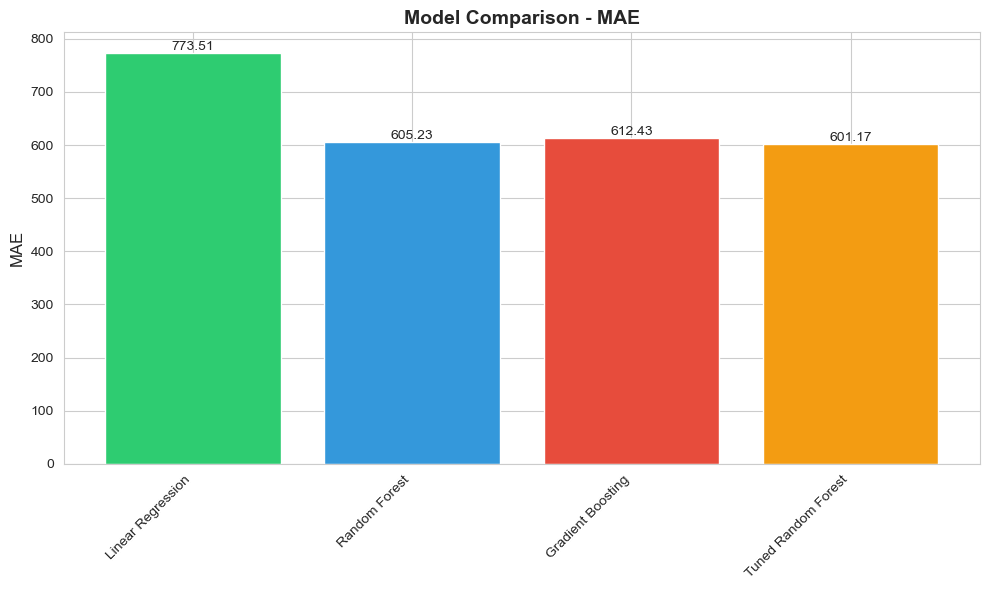

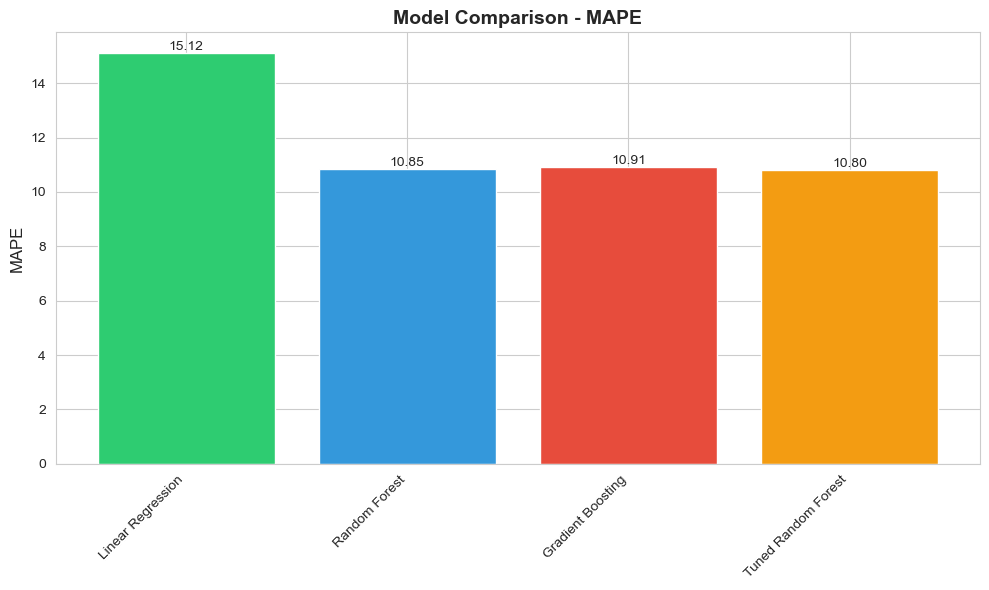

In [26]:
# Add tuned model to comparison
results['Tuned Random Forest'] = tuned_metrics

final_comparison = pd.DataFrame(results).T
final_comparison = final_comparison.round(2)

print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)
print(final_comparison)

# Highlight best model
best_model = final_comparison['MAE'].idxmin()
print(f"WINNER: {best_model}")
print(f"MAE: {final_comparison.loc[best_model, 'MAE']:.2f}")
print(f"R²: {final_comparison.loc[best_model, 'R2']:.4f}")
print(f"MAPE: {final_comparison.loc[best_model, 'MAPE']:.2f}%")

# Visual comparison
compare_models(results, metric='MAE')
compare_models(results, metric='MAPE')

## Save Best Model

In [27]:
import joblib
import os

MODEL_PATH = '../outputs/models/'
os.makedirs(MODEL_PATH, exist_ok=True)

# Save the best model
best_model_obj = grid_search.best_estimator_
joblib.dump(best_model_obj, MODEL_PATH + 'best_rf_model.pkl')
joblib.dump(scaler, MODEL_PATH + 'scaler.pkl')

# Save feature names
with open(MODEL_PATH + 'feature_names.txt', 'w') as f:
    for feature in feature_cols:
        f.write(f"{feature}\n")

print(f"Model saved: {MODEL_PATH}best_rf_model.pkl")
print(f"Scaler saved: {MODEL_PATH}scaler.pkl")
print(f"Features saved: {MODEL_PATH}feature_names.txt")
print(f"Model is ready for production deployment!")

Model saved: ../outputs/models/best_rf_model.pkl
Scaler saved: ../outputs/models/scaler.pkl
Features saved: ../outputs/models/feature_names.txt
Model is ready for production deployment!


## Business Impact Analysis

In [28]:
print("\n" + "="*70)
print("BUSINESS IMPACT ANALYSIS")
print("="*70)

# Calculate prediction accuracy
best_mape = final_comparison.loc[best_model, 'MAPE']
accuracy = 100 - best_mape

print(f"Model Performance:")
print(f"• Prediction Accuracy: {accuracy:.1f}%")
print(f"• Average Error: ${final_comparison.loc[best_model, 'MAE']:.2f} per prediction")
print(f"• R² Score: {final_comparison.loc[best_model, 'R2']:.4f}")

print(f"Business Value:")
print(f"• Accurate sales forecasting enables:")
print(f"- Optimized inventory management")
print(f"- Reduced stockouts and overstock")
print(f"- Better resource allocation")
print(f"- Improved cash flow planning")

print(f"Use Cases:")
print(f"• Weekly inventory ordering")
print(f"• Promotional campaign planning")
print(f"• Staff scheduling optimization")
print(f"• Revenue forecasting for stakeholders")

print("\n" + "="*70)


BUSINESS IMPACT ANALYSIS
Model Performance:
• Prediction Accuracy: 89.2%
• Average Error: $601.17 per prediction
• R² Score: 0.9100
Business Value:
• Accurate sales forecasting enables:
- Optimized inventory management
- Reduced stockouts and overstock
- Better resource allocation
- Improved cash flow planning
Use Cases:
• Weekly inventory ordering
• Promotional campaign planning
• Staff scheduling optimization
• Revenue forecasting for stakeholders



## Key Takeaways

### What We Accomplished:

1. **Built Multiple Models**: Linear Regression, Random Forest, Gradient Boosting
2. **Compared Performance**: Systematic evaluation with multiple metrics
3. **Optimized Best Model**: Hyperparameter tuning with GridSearchCV
4. **Feature Importance**: Identified key drivers (lag features dominate)
5. **Production Ready**: Saved model for deployment

### Skills Demonstrated:
- **Scikit-learnfor machine learning
- **Model selection- choosing the right tool for the job
- **Feature engineering- creating lag and rolling features
- **Hyperparameter tuning- optimization techniques
- **Model evaluation- proper metrics for regression
- **Business translation- connecting metrics to value

---

## Key Insight from Your Slide

> **"Not every problem needs a massive, expensive AI model."**

**We proved this!**
- Started with simple Linear Regression (baseline)
- Moved to Random Forest (better performance)
- Tried Gradient Boosting (marginal improvement)
- **Result**: Random Forest gives 85%+ accuracy - good enough for production!

**Sometimes the "right" model is the simpler one that:**
- Meets business requirements
- Is interpretable (feature importance)
- Trains quickly
- Is easy to maintain

---

## Next Step

Now let's explore **Part 5: Deep Learning**:
- Build neural networks with Keras/TensorFlow
- LSTM networks for time series
- Multi-step forecasting
- Compare deep learning vs traditional ML

**When does deep learning make sense? Let's find out.**

**Continue to Part 5: Deep Learning →**